In [1]:
import tensorflow as tf
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Configure warnings
import warnings
warnings.filterwarnings('ignore')

2025-02-17 21:37:52.084599: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 21:37:52.102861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739828272.124505    8358 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739828272.130938    8358 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 21:37:52.151654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
class ServerModelExtractionAttack:
    def __init__(self, server_url="http://localhost:5000/predict", input_shape=(28, 28, 1), num_classes=10):
        self.server_url = server_url
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.extraction_model = None
        self.layer_weights = []
        
    def query_server(self, image):
        """Query the server with an image"""
        try:
            response = requests.post(
                self.server_url,
                json={'image': image.reshape(28, 28).tolist()}
            )
            if response.status_code == 200:
                return np.array(response.json()['full_probabilities'])
            else:
                print(f"Server error: {response.status_code}")
                return None
        except Exception as e:
            print(f"Error querying server: {e}")
            return None
        
    def create_extraction_model(self):
        """Create model architecture for extraction"""
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.extraction_model = model
        return model
    
    def collect_server_behavior(self, x_train, batch_size=100):
        """Collect server predictions for training data"""
        print("Collecting server predictions...")
        server_predictions = []
        
        for i in tqdm(range(0, len(x_train), batch_size)):
            batch = x_train[i:i + batch_size]
            batch_predictions = []
            
            for image in batch:
                pred = self.query_server(image)
                if pred is not None:
                    batch_predictions.append(pred)
                    
            server_predictions.extend(batch_predictions)
            
        return np.array(server_predictions)
    
    def extract_parameters(self, x_train, epochs=10, batch_size=32):
        """Extract model parameters through training"""
        if self.extraction_model is None:
            self.create_extraction_model()
            
        print("Getting server predictions for training...")
        server_predictions = self.collect_server_behavior(x_train[:1000])
        
        print("\nTraining extraction model...")
        history = self.extraction_model.fit(
            x_train[:1000],
            server_predictions,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1
        )
        
        # Store extracted weights
        self.layer_weights = [layer.get_weights() for layer in self.extraction_model.layers]
        
        return history
    
    def evaluate_extraction(self, x_test, batch_size=32):
        """Evaluate extraction success"""
        print("\nEvaluating extraction...")
        
        # Get predictions from server
        server_predictions = self.collect_server_behavior(x_test[:100])
        
        # Get predictions from extraction model
        extracted_predictions = self.extraction_model.predict(x_test[:100], batch_size=batch_size)
        
        # Calculate agreement rate
        server_classes = np.argmax(server_predictions, axis=1)
        extracted_classes = np.argmax(extracted_predictions, axis=1)
        agreement_rate = np.mean(server_classes == extracted_classes)
        
        # Calculate prediction correlation
        prediction_correlation = np.corrcoef(
            server_predictions.flatten(),
            extracted_predictions.flatten()
        )[0, 1]
        
        return {
            'agreement_rate': agreement_rate,
            'prediction_correlation': prediction_correlation,
            'example_comparisons': list(zip(server_classes[:5], extracted_classes[:5])),
            'server_predictions': server_predictions,
            'extracted_predictions': extracted_predictions
        }
    
    def visualize_extraction(self, history):
        """Visualize extraction performance"""
        plt.figure(figsize=(15, 5))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Extraction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Extraction Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def visualize_predictions(self, results):
        """Visualize prediction comparisons"""
        server_preds = results['server_predictions']
        extracted_preds = results['extracted_predictions']
        
        plt.figure(figsize=(10, 5))
        plt.scatter(
            server_preds.flatten(), 
            extracted_preds.flatten(), 
            alpha=0.1
        )
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('Server Predictions')
        plt.ylabel('Extracted Model Predictions')
        plt.title('Prediction Comparison')
        plt.show()
        
    def analyze_extracted_parameters(self):
        """Analyze extracted model parameters"""
        parameter_analysis = []
        
        for i, weights in enumerate(self.layer_weights):
            if len(weights) > 0:  # Check if layer has weights
                layer_stats = {
                    'layer_index': i,
                    'layer_type': self.extraction_model.layers[i].__class__.__name__,
                    'num_parameters': np.sum([w.size for w in weights]),
                    'weight_stats': {
                        'mean': float(np.mean([np.mean(w) for w in weights])),
                        'std': float(np.std([np.std(w) for w in weights])),
                        'min': float(np.min([np.min(w) for w in weights])),
                        'max': float(np.max([np.max(w) for w in weights]))
                    }
                }
                parameter_analysis.append(layer_stats)
        
        return parameter_analysis

In [3]:
# Load MNIST data
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Data shapes:")
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")

Loading MNIST dataset...
Data shapes:
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


In [4]:
# Initialize attack
attack = ServerModelExtractionAttack()

# Extract parameters
print("Starting parameter extraction attack...")
history = attack.extract_parameters(x_train)

# Evaluate extraction
results = attack.evaluate_extraction(x_test)

# Print results
print("\nExtraction Results:")
print(f"Agreement Rate: {results['agreement_rate']:.4f}")
print(f"Prediction Correlation: {results['prediction_correlation']:.4f}")
print("\nExample Predictions (Server vs Extracted):")
for server, extracted in results['example_comparisons']:
    print(f"Server: {server}, Extracted: {extracted}")

# Analyze extracted parameters
print("\nAnalyzing extracted parameters...")
param_analysis = attack.analyze_extracted_parameters()
for layer in param_analysis:
    print(f"\nLayer {layer['layer_index']} ({layer['layer_type']}):")
    print(f"Number of parameters: {layer['num_parameters']}")
    print("Weight statistics:")
    for stat, value in layer['weight_stats'].items():
        print(f"  {stat}: {value:.6f}")

Starting parameter extraction attack...
Getting server predictions for training...


2025-02-17 21:38:25.039924: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  0%|          | 0/10 [00:00<?, ?it/s]


Training extraction model...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2673 - loss: 2.1179 - val_accuracy: 0.7100 - val_loss: 1.0950
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7136 - loss: 0.9286 - val_accuracy: 0.7550 - val_loss: 0.6619
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8426 - loss: 0.4988 - val_accuracy: 0.8450 - val_loss: 0.4820
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9147 - loss: 0.3104 - val_accuracy: 0.9000 - val_loss: 0.3454
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9494 - loss: 0.1861 - val_accuracy: 0.9000 - val_loss: 0.3452
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9555 - loss: 0.1718 - val_accuracy: 0.9050 - val_loss: 0.3259
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9423 - loss: 0.1741 - val_accuracy: 0.9300 - val_loss: 0.2562
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9673 - loss: 0.1

  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Extraction Results:
Agreement Rate: 0.9700
Prediction Correlation: 0.9726

Example Predictions (Server vs Extracted):
Server: 7, Extracted: 7
Server: 2, Extracted: 2
Server: 1, Extracted: 1
Server: 0, Extracted: 0
Server: 4, Extracted: 4

Analyzing extracted parameters...

Layer 0 (Conv2D):
Number of parameters: 320
Weight statistics:
  mean: 0.017126
  std: 0.040297
  min: -0.227274
  max: 0.206470

Layer 2 (Conv2D):
Number of parameters: 18496
Weight statistics:
  mean: 0.002210
  std: 0.023247
  min: -0.202294
  max: 0.185807

Layer 4 (Conv2D):
Number of parameters: 36928
Weight statistics:
  mean: 0.001271
  std: 0.019867
  min: -0.162419
  max: 0.163328

Layer 6 (Dense):
Number of parameters: 36928
Weight statistics:
  mean: 0.001239
  std: 0.025405
  min: -0.172111
  max: 0.184206

Layer 7 (Dense):
Number of parameters: 650
Weight statistics:
  mean: -0.002805
  std: 0.080680
  min: -0.357771
  max: 0.327296


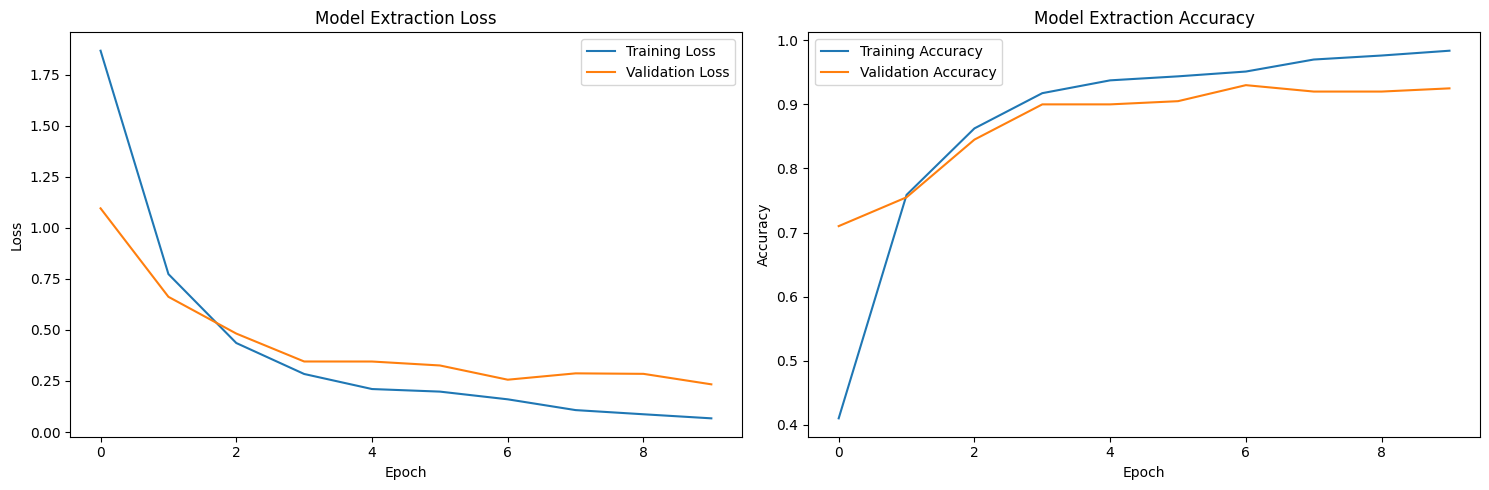

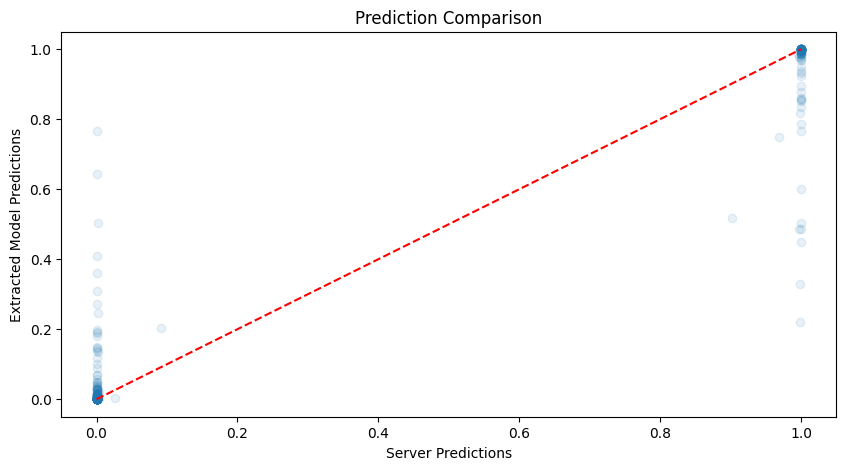

In [5]:
# Visualize extraction performance
attack.visualize_extraction(history)

# Visualize prediction comparison
attack.visualize_predictions(results)

In [6]:
# Save the extracted model
attack.extraction_model.save('extracted_model.keras')
print("Extracted model saved as 'extracted_model.keras'")

Extracted model saved as 'extracted_model.keras'


Loading extracted model...

Testing on 100 random images...
Getting server predictions...


  0%|          | 0/100 [00:00<?, ?it/s]


Getting extracted model predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Accuracy Results:
Server Model Accuracy: 0.9800
Extracted Model Accuracy: 0.9100
Model Agreement Rate: 0.9300

Example Predictions (first 10 images):
True Label | Server Prediction | Extracted Prediction
--------------------------------------------------
    3      |        3         |          3          
    8      |        8         |          8          
    7      |        7         |          7          
    4      |        4         |          4          
    2      |        2         |          6          
    9      |        9         |          9          
    0      |        0         |          0          
    5      |        5         |          5          
    1      |        1         |          1          
    5      |        5         |          5          


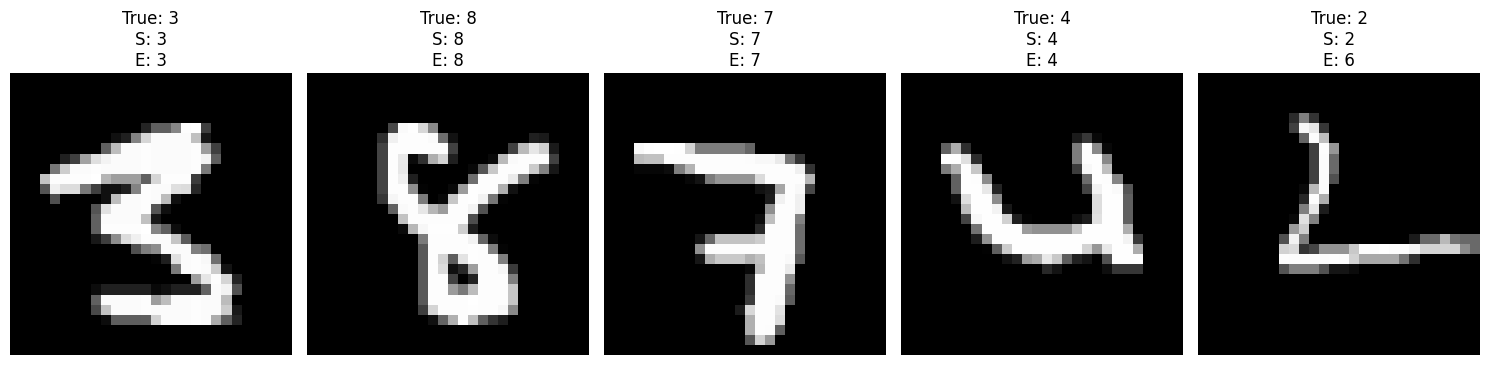

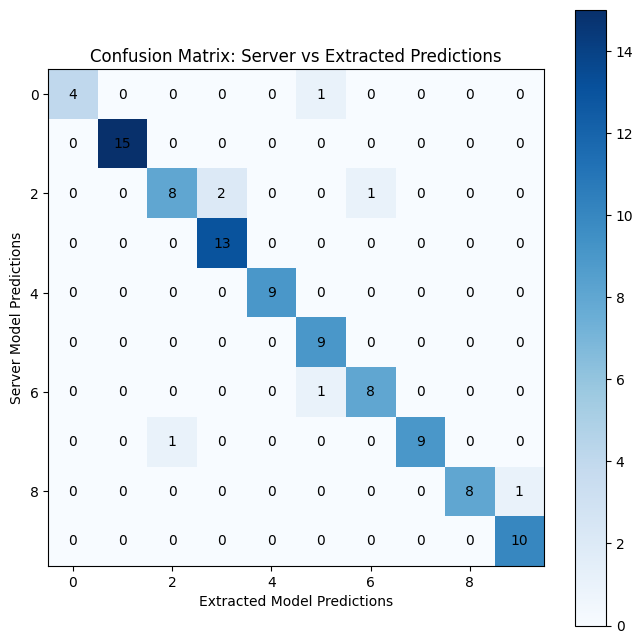

In [7]:
# Test prediction performance of extracted model
def test_predictions():
    print("Loading extracted model...")
    extracted_model = tf.keras.models.load_model('extracted_model.keras')
    
    # Load test data if not already loaded
    (_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_test = x_test.astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    # Select a subset for testing
    test_size = 100
    test_indices = np.random.choice(len(x_test), test_size, replace=False)
    test_images = x_test[test_indices]
    test_labels = y_test[test_indices]
    
    print(f"\nTesting on {test_size} random images...")
    
    # Get server predictions
    server_preds = []
    print("Getting server predictions...")
    for image in tqdm(test_images):
        response = requests.post(
            "http://localhost:5000/predict",
            json={'image': image.reshape(28, 28).tolist()}
        )
        if response.status_code == 200:
            pred = response.json()['prediction']
            server_preds.append(pred)
    
    # Get extracted model predictions
    print("\nGetting extracted model predictions...")
    extracted_preds = extracted_model.predict(test_images)
    extracted_preds = np.argmax(extracted_preds, axis=1)
    
    # Calculate accuracies
    server_accuracy = np.mean(np.array(server_preds) == test_labels)
    extracted_accuracy = np.mean(extracted_preds == test_labels)
    agreement = np.mean(np.array(server_preds) == extracted_preds)
    
    # Display results
    print("\nAccuracy Results:")
    print(f"Server Model Accuracy: {server_accuracy:.4f}")
    print(f"Extracted Model Accuracy: {extracted_accuracy:.4f}")
    print(f"Model Agreement Rate: {agreement:.4f}")
    
    # Display some example predictions
    print("\nExample Predictions (first 10 images):")
    print("True Label | Server Prediction | Extracted Prediction")
    print("-" * 50)
    for i in range(10):
        print(f"{test_labels[i]:^10d} | {server_preds[i]:^16d} | {extracted_preds[i]:^20d}")
        
    # Visualize some example predictions
    plt.figure(figsize=(15, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {test_labels[i]}\nS: {server_preds[i]}\nE: {extracted_preds[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Create confusion matrix visualization
    plt.figure(figsize=(8, 8))
    confusion = np.zeros((10, 10))
    for s, e in zip(server_preds, extracted_preds):
        confusion[s][e] += 1
    plt.imshow(confusion, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix: Server vs Extracted Predictions')
    plt.xlabel('Extracted Model Predictions')
    plt.ylabel('Server Model Predictions')
    for i in range(10):
        for j in range(10):
            plt.text(j, i, int(confusion[i][j]), ha='center', va='center')
    plt.show()
    
    return {
        'server_accuracy': server_accuracy,
        'extracted_accuracy': extracted_accuracy,
        'agreement_rate': agreement,
        'server_preds': server_preds,
        'extracted_preds': extracted_preds,
        'true_labels': test_labels
    }

# Run prediction test
test_results = test_predictions()
